# Examples of XAI-Lib Usage for MNIST data

In [1]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 560 (delta 147), reused 436 (delta 96), pack-reused 0
Receiving objects: 100% (560/560), 273.50 MiB | 32.32 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Checking out files: 100% (377/377), done.


In [2]:
cd XAI-course_2021/Images/

/content/XAI-course_2021/Images


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

## Intgrad (Tensorflow Model)

<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/intgrad_MNIST.jpg?raw=1' width="20%" height="20%">

In [2]:
# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()
#MNIST_x_data_train = np.load('./datasets/mnist_x_train.npy')
#MNIST_y_data_train = np.load('./datasets/mnist_y_train.npy')
#MNIST_x_data_test = np.load('./datasets/mnist_x_test.npy')
#MNIST_y_data_test = np.load('./datasets/mnist_y_test.npy')

# Load the model
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'
MNIST_CNN_tf = tf.keras.models.load_model('./models/keras_cnn_mnist')
MNIST_CNN_tf.trainable=False
MNIST_CNN_tf.summary()

2022-01-20 15:25:12.312133: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [3]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN_tf)

In [4]:
# 2) Fit the Explainer
ig.fit()

In [13]:
# 3) Select the image we want to give an explanation for
idx = 80
image = MNIST_x_data_train[idx,:]

In [8]:
# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box no first dimension
def preprocessing(image):
    return tf.convert_to_tensor(image.reshape(28,28,1),dtype=tf.float32)

In [9]:
# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN_tf(image)

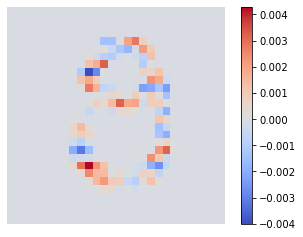

In [11]:
# 5) Explain an Instance
intgrad_tf_score = ig.explain(image, 8, 'black', preprocessing, predict, model_type='tensorflow')

plt.imshow(intgrad_tf_score.reshape(28,28), cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## Intgrad (PyTorch Model)

In [3]:
# Load Dataset
#import torchvision
#import torchvision.datasets as datasets
#mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
#mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)
#from tensorflow.keras.datasets import mnist
#(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

# Load the model
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        
        return x
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


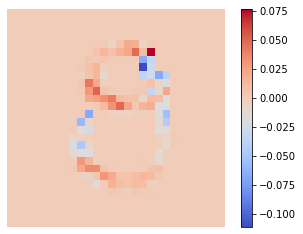

In [15]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[idx]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor([[image/255]]).float()

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN(image)

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, 5, 'black', preprocessing, predict, model_type='pytorch').reshape(28,28)

plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

In [9]:
!pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=dd724b70215cc833aa61fef61b0577efd1280a3f826040a89628b8f0898283f0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/lime_MNIST.jpg?raw=1' width="50%" height="50%">

100%|██████████| 100/100 [00:00<00:00, 509.57it/s]


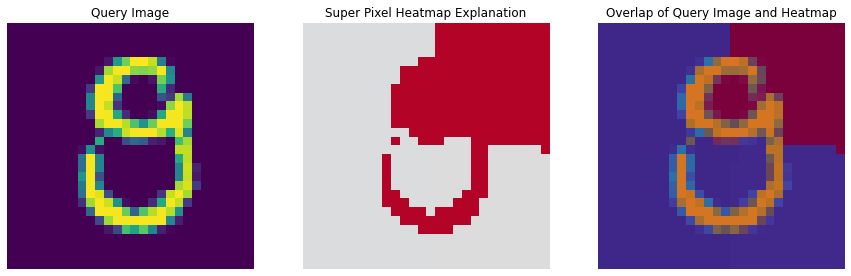

In [16]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 80

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, num_samples=100)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

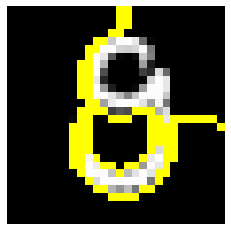

In [17]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0])
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

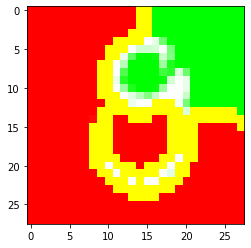

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

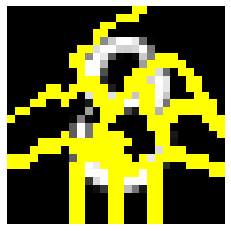

In [20]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[idx].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=2, max_dist=3)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

100%|██████████| 100/100 [00:00<00:00, 513.63it/s]


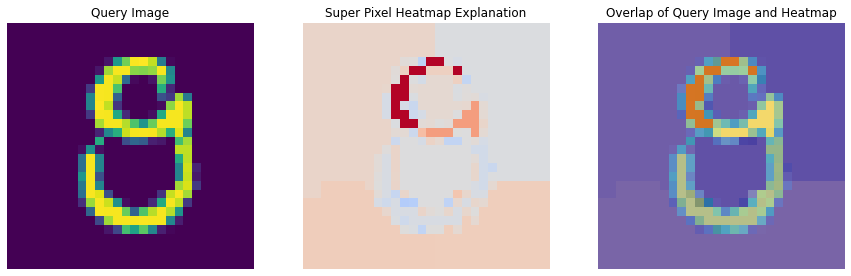

In [22]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 80

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, segmentation_fn, num_samples=100)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

In [23]:
lime_score = explanation.heatmap

## RISE

<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/rise_MNIST.jpg?raw=1' width="50%" height="50%">

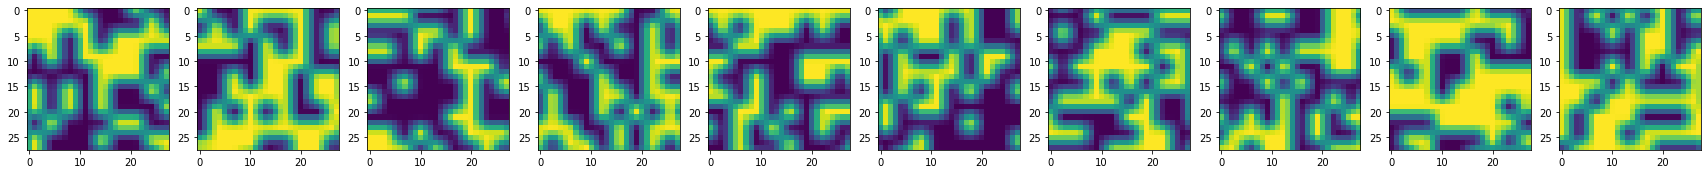

In [24]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        return self.model(torch.tensor(X).reshape(-1,1,28,28).float()/255).detach().numpy()
        

model = Rise_model_wrapper(MNIST_CNN, (28,28))
rise = RiseXAIImageExplainer(model)
        

N = 10 # number of random masks
s = 10 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

F,ax=plt.subplots(1,10,figsize=(30,5))
for i in range(10):
    ax[i].imshow(rise.masks[i,:].reshape(28,28))

(10, 28, 28)


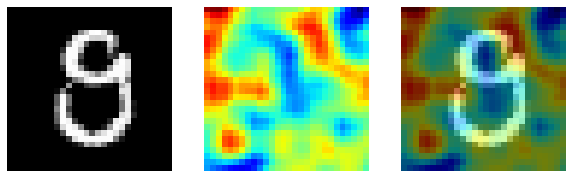

In [26]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = MNIST_x_data_train[80,:]
N = 100
s = 8
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img.reshape(28,28,1)/255)
print(sal.shape)
rise_score = sal[MNIST_y_data_test[8]]

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(rise_score,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(rise_score,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM
Weight the 2D activations by the average gradient

In [18]:
!pip install ttach

In [27]:
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [29]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 8, model_type='pytorch')
gradcam_pt_score = attr[0,:]

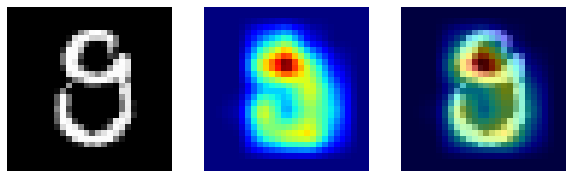

In [30]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [32]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 8, model_type='tensorflow')
gradcam_tf_score = attr

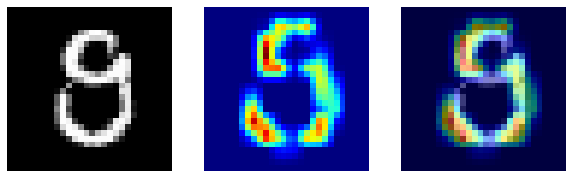

In [33]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM++
Like GradCAM but uses second order gradients

In [34]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

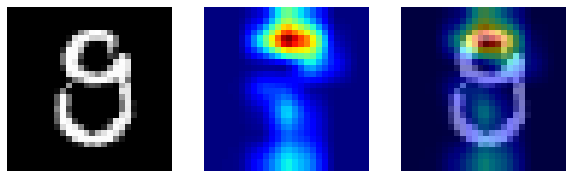

In [35]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [36]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 8, model_type='tensorflow')
gradcampp_tf_score = attr

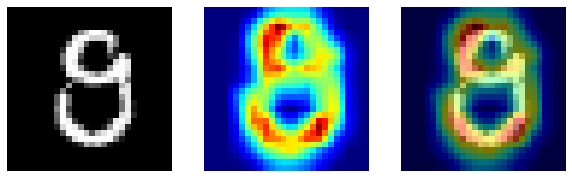

In [37]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

In [ ]:
methods = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score]
F, ax = plt.subplots(1,6,figsize=(20,5))
for i in range(6):
    ax[i].axis(False)
    ax[i].imshow(methods[i],cmap='coolwarm')

In [ ]:
image = MNIST_x_data_train[0:1]
plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.axis(False);

In [ ]:
from xailib.metrics.insertiondeletion import ImageInsDel
import torch

# Load the model
MNIST_CNN

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 28
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

In [ ]:
from sklearn.metrics import auc

y = metric(image, 28, intgrad_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

In [ ]:
from scipy.ndimage.filters import gaussian_filter
CH = 1
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=11, ksig=5):

    kern = gkern(klen, ksig)
    image = torch.tensor(np.expand_dims(image, 0)).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)[0,:]

F,ax = plt.subplots(1,2)
ax[0].imshow(image[0,:], cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(image)[0,:],cmap='gray')
ax[1].axis(False);

In [ ]:
from xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 10
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

In [ ]:
from sklearn.metrics import auc

y = metric(image, 28, intgrad_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

In [ ]:
y = metric(image, 28, intgrad_pt_score, rgb=False, verbose=2)